# RGDR & traintest
This notebook demonstrates how to use RGDR in a train-test splitting scenario, to get the data ready for training a ML model.

First we import the required modules and load in the example data.

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR
from sklearn.model_selection import ShuffleSplit
import s2spy.traintest

file_path = '../../s2spy/tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target_data = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc').sel(cluster=3)

cal = s2spy.time.AdventCalendar('08-01', freq = "30d")
cal = cal.map_to_data(field)

field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target_data)

As precursor we select the 'sst' DataArray, at `i_interval=-7` (7th interval before the anchor).

The target is the (preclustered) 'st' DataArray, at the first target interval.

In [4]:
precursor = field_resampled['sst'].sel(i_interval=-7)
target = target_resampled['ts'].sel(i_interval=1)

We define our train-test splitting strategy with "ShuffleSplit", and also define the RGDR settings we will use. 

It is essential to use different `RGDR` objects for each split, as the object stores the information required to transform the test data. Here we make a list of different RGDR objects (all with the same settings), with the same length as the number of splits.

In [5]:
seed = 1 #same 'randomness'
n_splits = 4

shufflesplit = ShuffleSplit(n_splits=n_splits, test_size=0.25, random_state = seed)
cv = s2spy.traintest.TrainTestSplit(shufflesplit)

rgdrs = [RGDR(eps_km=800, alpha=0.10, min_area_km2=0) for _ in range(n_splits)]

Using the traintest cv, we can split the target and precursor data into train and test sets. For easy tracking we put all the splits in a list.

In [7]:
target_timeseries_splits = []
precursor_field_splits = []
for x_train, x_test, y_train, y_test in cv.split(precursor, y=target):
    target_timeseries_splits.append(target.sel(anchor_year=x_train["anchor_year"].values))
    precursor_field_splits.append(precursor.sel(anchor_year=x_train["anchor_year"].values))

Using the `preview_clusters` functionality, we can display what our clusters will look like, for each split.

Note that there is a single consistent cluster over all splits, but that the top-right plot contains three clusters.

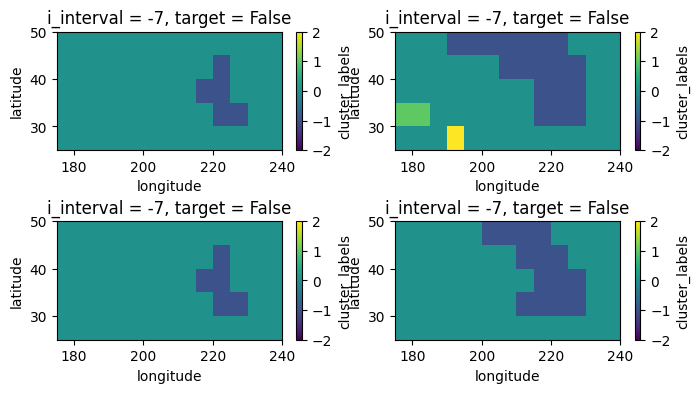

In [8]:
fig, axs = plt.subplots(
    ncols=2,
    nrows=n_splits//2,
    figsize=(8, 4),
    gridspec_kw={'hspace':0.6}
)
axs = axs.flatten()

for split in range(n_splits):
    _ = rgdrs[split].preview_clusters(
        precursor_field_splits[split],
        target_timeseries_splits[split], 
        ax=axs[split],
        vmin=-2, vmax=2
    )

With a (list-comprehension) `for` loop, we can fit and apply RGDR to each split:

In [12]:
clustered_precursors = [
    rgdrs[i].fit_transform(precursor_field_splits[i], target_timeseries_splits[i])
    for i in range(n_splits)
    ]

We can see the labels of the clusters. These are named based on which `i_interval` was used for the precursor, and then named based on how many clusters there are in each `i_interval`. This leads to long names, which can be inconsistent over splits, as no information is passed between the different RGDR instances to avoid data leakage.

In [13]:
for el in clustered_precursors:
    print(el.cluster_labels.values)

['i_interval:-7_cluster:-1']
['i_interval:-7_cluster:-1' 'i_interval:-7_cluster:1'
 'i_interval:-7_cluster:2']
['i_interval:-7_cluster:-1']
['i_interval:-7_cluster:-1']


However, using the `label_alignment` module we can align labels over different splits. `label_alignment` will try to match clusters over different splits, and then _only rename_ the clusters.

Clusters will be assigned a letter as name.

In [15]:
aligned_precursors = s2spy.rgdr.label_alignment.rename_labels(rgdrs, clustered_precursors)
    
for el in aligned_precursors:
    print(el.cluster_labels.values)

['A']
['A' 'C' 'B']
['A']
['A']


In [21]:
aligned_precursors[1]

<xarray.DataArray 'sst' (anchor_year: 29, cluster_labels: 3)>
284.0 291.9 295.1 284.9 289.6 294.5 ... 284.9 290.1 293.9 284.6 290.3 294.1
Coordinates:
  * anchor_year     (anchor_year) int64 2008 1996 1985 2016 ... 2005 1994 2010
    i_interval      int64 -7
    target          bool False
  * cluster_labels  (cluster_labels) <U32 'A' 'C' 'B'
    latitude        (cluster_labels) float64 41.48 32.5 27.5
    longitude       (cluster_labels) float64 215.8 180.0 192.5
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

After the labels are aligned, it is possible to concatenate the clustered precursors if you would like to do so:

In [16]:
aligned_merged = xr.concat(aligned_precursors, "split")
aligned_merged = aligned_merged.dropna(dim='cluster_labels', how='all')
xr.set_options(display_expand_data=False)
aligned_merged

<xarray.DataArray 'sst' (split: 4, anchor_year: 39, cluster_labels: 3)>
288.4 nan nan 288.6 nan nan nan nan nan ... nan nan 285.6 nan nan 286.2 nan nan
Coordinates:
  * anchor_year     (anchor_year) int64 1980 1981 1982 1983 ... 2016 2017 2018
  * cluster_labels  (cluster_labels) <U32 'A' 'B' 'C'
    i_interval      int64 -7
    target          bool False
    latitude        (split, cluster_labels) float64 36.32 nan nan ... nan nan
    longitude       (split, cluster_labels) float64 222.6 nan nan ... nan nan
Dimensions without coordinates: split
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...